In [ ]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut, train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

folder_paths = [
    'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT-UNIBZ/Dataset/Iron-Stress/Late',
    'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT-UNIBZ/Dataset/Iron-Stress/Early',
    'C:/Users/halhajali/OneDrive - Fondazione Istituto Italiano Tecnologia/Desktop/IIT-UNIBZ/Dataset/Iron-Stress/Control',
]
plants = ['plant0','plant1','plant3']
random.seed(42)
np.random.seed(42)
indices = [198,199, 187]  ##Add only the indices of the top-weighted frequencies 
def load_plant_data_with_ids():
    all_data, labels, plant_ids = [], [], []
    for label, folder_path in enumerate(folder_paths):
        for plant in plants:
            plant_folder = os.path.join(folder_path, plant)
            if not os.path.exists(plant_folder): continue
            for filename in os.listdir(plant_folder):
                if filename.endswith('.csv'):
                    sample = pd.read_csv(os.path.join(plant_folder, filename), header=None)
                    data = np.array(sample).take(indices, axis=0)[:, [3, 4]]
                    data = data.flatten()
                    # data = np.array(sample)[:, [3,4]].flatten()
                    # data = data[indices]
                    # print(data.shape)
                    # print(data)
                    all_data.append(data)
                    labels.append(label)
                    plant_ids.append(plant)
    return np.array(all_data), np.array(labels), np.array(plant_ids)

X, y, plant_ids = load_plant_data_with_ids()
unique_plants = np.unique(plant_ids)
print(f"Data shape: {X.shape}, Labels shape: {y.shape}, Unique plants: {unique_plants}")

Data shape: (1956, 6), Labels shape: (1956,), Unique plants: ['plant0' 'plant1' 'plant3']


c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Fold 1 | Test Plant: plant0
Best Val Accuracy: 0.8990
Test Accuracy: 0.8438
---


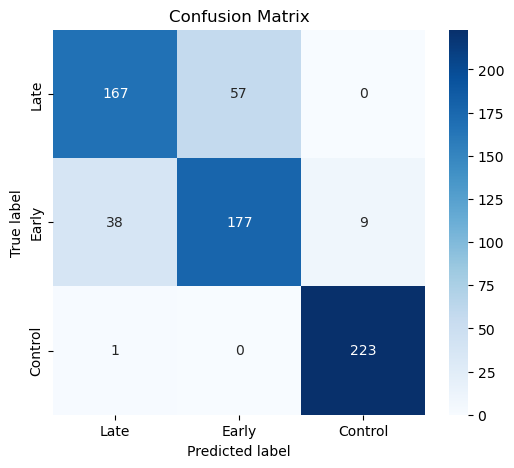

Fold 2 | Test Plant: plant1
Best Val Accuracy: 0.8861
Test Accuracy: 0.8350
---


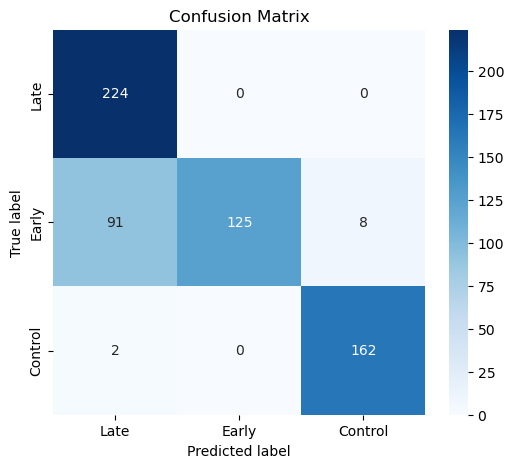

c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\halhajali\AppData\Local\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\halhajali\A

Fold 3 | Test Plant: plant3
Best Val Accuracy: 0.8808
Test Accuracy: 0.8571
---


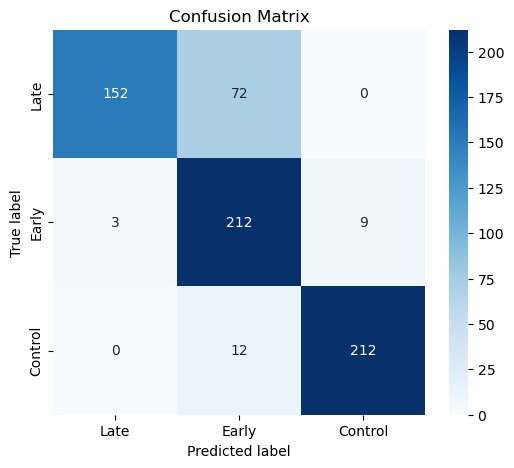


=== Final Results ===
   fold test_plant  val_accuracy  test_accuracy
0     1     plant0      0.898964       0.843750
1     2     plant1      0.886139       0.834967
2     3     plant3      0.880829       0.857143

Mean Validation Accuracy: 0.8886 ± 0.0093
Mean Test Accuracy: 0.8453 ± 0.0112


In [44]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

logo = LeaveOneGroupOut()
param_grid = {
   'C': [0.1, 1,5,20,40, 10,50, 100],
   'l1_ratio': [0.1, 0.3, 0.5, 1, 0.7],
#  'C': [100],
  #'l1_ratio': [1],
}
results = []
best_models = []
for fold_idx, (train_val_idx, test_idx) in enumerate(logo.split(X, y, groups=plant_ids)):
    # print(train_val_idx.shape)
    # print(test_idx)
    X_train_val, X_test = X[train_val_idx], X[test_idx]
    y_train_val, y_test = y[train_val_idx], y[test_idx]
    plant_ids_train_val = plant_ids[train_val_idx]
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, 
        test_size=0.3, 
        stratify=y_train_val,
        random_state=42
    )
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    best_fold_model = None
    best_fold_val_accuracy = 0
    for C in param_grid['C']:
        for l1_ratio in param_grid['l1_ratio']:
            model = LogisticRegression(
                multi_class='multinomial',
                penalty='elasticnet',
                solver='saga',
                C=C,
                l1_ratio=l1_ratio,
                max_iter=2000
            )
            model.fit(X_train_scaled, y_train)
            val_acc = accuracy_score(y_val, model.predict(X_val_scaled))
            if val_acc > best_fold_val_accuracy:
                best_fold_val_accuracy = val_acc
                best_fold_model = model
                best_fold_scaler = scaler

    test_acc = accuracy_score(y_test, best_fold_model.predict(X_test_scaled))
    y_pred_test = best_fold_model.predict(X_test_scaled)

    results.append({
        'fold': fold_idx + 1,
        'test_plant': unique_plants[fold_idx],
        'best_params': {
            'C': best_fold_model.C,
            'l1_ratio': best_fold_model.l1_ratio
        },
        'val_accuracy': best_fold_val_accuracy,
        'test_accuracy': test_acc
    })
    
    print(f"Fold {fold_idx + 1} | Test Plant: {unique_plants[fold_idx]}")
    print(f"Best Val Accuracy: {best_fold_val_accuracy:.4f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    print("---")
    cm = confusion_matrix(y_test, y_pred_test, labels=[0, 1, 2])
    class_names = ['Late', 'Early', 'Control']

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

    best_models.append(best_fold_model)

print("\n=== Final Results ===")
df_results = pd.DataFrame(results)
print(df_results[['fold', 'test_plant', 'val_accuracy', 'test_accuracy']])

print(f"\nMean Validation Accuracy: {df_results['val_accuracy'].mean():.4f} ± {df_results['val_accuracy'].std():.4f}")
print(f"Mean Test Accuracy: {df_results['test_accuracy'].mean():.4f} ± {df_results['test_accuracy'].std():.4f}")